In [1]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

import tensorflow
from tensorflow.python.keras.engine import training
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Convolution2D, Add, Activation, PReLU, Dense, Input

from deepface.commons import functions
from deepface.commons import distance as dst
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Load SphereFace model

In [2]:
model = cv2.dnn.readNetFromCaffe("sphereface_deploy.prototxt", "sphereface_model.caffemodel")

In [3]:
source = {}

for layer in model.getLayerNames():
    
    #------------------------------------------
    #weight
    
    if 'conv' in layer:
        weight = model.getParam(layer, 0)
        
        #find symmetrical one
        weight = np.moveaxis(weight, 2, 3)
        weight = np.moveaxis(weight, 1, 3)
        weight = np.moveaxis(weight, 0, 3)
        
        print("%s.weight" % (layer),weight.shape)
        
        source["%s.weight" % (layer)] = weight
    
    if 'relu' in layer:
        weight = model.getParam(layer, 0)
        weight = np.moveaxis(weight, -1, 0)
        weight = np.expand_dims(weight, axis = 0)
        print("%s.weight" % (layer), weight.shape)
        source["%s.weight" % (layer)] = weight
    
    if 'fc' in layer:
        weight = model.getParam(layer, 0)
        weight = np.moveaxis(weight, -1, 0)
        print("%s.weight" % (layer), weight.shape)
        source["%s.weight" % (layer)] = weight
        
    #------------------------------------------
    #bias
    
    if 'conv' in layer:
        weight = model.getParam(layer, 1)
        
        weight = weight.reshape(weight.shape[0])
        print("%s.bias"% (layer), weight.shape)
        source["%s.bias"% (layer)] = weight
    
    if 'fc' in layer:
        weight = model.getParam(layer, 1)[0]
        print("%s.bias"% (layer), weight.shape)
        source["%s.bias"% (layer)] = weight

conv1_1.weight (3, 3, 3, 64)
conv1_1.bias (64,)
relu1_1.weight (1, 1, 64)
conv1_2.weight (3, 3, 64, 64)
conv1_2.bias (64,)
relu1_2.weight (1, 1, 64)
conv1_3.weight (3, 3, 64, 64)
conv1_3.bias (64,)
relu1_3.weight (1, 1, 64)
conv2_1.weight (3, 3, 64, 128)
conv2_1.bias (128,)
relu2_1.weight (1, 1, 128)
conv2_2.weight (3, 3, 128, 128)
conv2_2.bias (128,)
relu2_2.weight (1, 1, 128)
conv2_3.weight (3, 3, 128, 128)
conv2_3.bias (128,)
relu2_3.weight (1, 1, 128)
conv2_4.weight (3, 3, 128, 128)
conv2_4.bias (128,)
relu2_4.weight (1, 1, 128)
conv2_5.weight (3, 3, 128, 128)
conv2_5.bias (128,)
relu2_5.weight (1, 1, 128)
conv3_1.weight (3, 3, 128, 256)
conv3_1.bias (256,)
relu3_1.weight (1, 1, 256)
conv3_2.weight (3, 3, 256, 256)
conv3_2.bias (256,)
relu3_2.weight (1, 1, 256)
conv3_3.weight (3, 3, 256, 256)
conv3_3.bias (256,)
relu3_3.weight (1, 1, 256)
conv3_4.weight (3, 3, 256, 256)
conv3_4.bias (256,)
relu3_4.weight (1, 1, 256)
conv3_5.weight (3, 3, 256, 256)
conv3_5.bias (256,)
relu3_5.weight

In [4]:
source_layers = list(source.keys())

# Build Keras Model

In [5]:
#Building SphereFace in Keras is heavily inspired the repo: https://github.com/radonys/SphereFace-Keras/blob/master/sphereface_20.py
    
shared_axes = [1, 2]

img_input = Input(shape=(96, 112, 3)) #torch shape: (1,3,112,96)

#Conv 1.X

conv1_1 = Convolution2D(64, 3, strides=2, padding='same', use_bias=True, bias_initializer='zeros', name = 'conv1_1')(img_input)
relu1_1 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu1_1')(conv1_1)
    
conv1_2 = Convolution2D(64, 3, strides=1, padding='same', bias_initializer='zeros', name = 'conv1_2')(relu1_1)
relu1_2 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu1_2')(conv1_2)

conv1_3 = Convolution2D(64, 3, strides=1, padding='same', bias_initializer='zeros', name = 'conv1_3')(relu1_2)
relu1_3 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu1_3')(conv1_3)

res1_3 = Add()([relu1_1, relu1_3])

#Conv 2.X

conv2_1 = Convolution2D(128, 3, strides=2, padding='same', use_bias=True, bias_initializer='zeros', name = 'conv2_1')(res1_3)
relu2_1 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu2_1')(conv2_1)

conv2_2 = Convolution2D(128, 3, strides=1, padding='same', bias_initializer='zeros', name = 'conv2_2')(relu2_1)
relu2_2 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu2_2')(conv2_2)

conv2_3 = Convolution2D(128, 3, strides=1, padding='same', bias_initializer='zeros', name = 'conv2_3')(relu2_2)
relu2_3 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu2_3')(conv2_3)

res2_3 = Add()([relu2_1, relu2_3])

conv2_4 = Convolution2D(128, 3, strides=1, padding='same', bias_initializer='zeros', name = 'conv2_4')(res2_3)
relu2_4 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu2_4')(conv2_4)

conv2_5 = Convolution2D(128, 3, strides=1, padding='same', bias_initializer='zeros', name = 'conv2_5')(relu2_4)
relu2_5 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu2_5')(conv2_5)

res2_5 = Add()([res2_3, relu2_5])

#Conv 3.X

conv3_1 = Convolution2D(256, 3, strides=2, padding='same', use_bias=True, bias_initializer='zeros', name = 'conv3_1')(res2_5)
relu3_1 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu3_1')(conv3_1)

conv3_2 = Convolution2D(256, 3, strides=1, padding='same', bias_initializer='zeros', name = 'conv3_2')(relu3_1)
relu3_2 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu3_2')(conv3_2)

conv3_3 = Convolution2D(256, 3, strides=1, padding='same', bias_initializer='zeros', name = 'conv3_3')(relu3_2)
relu3_3 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu3_3')(conv3_3)

res3_3 = Add()([relu3_1, relu3_3])

conv3_4 = Convolution2D(256, 3, strides=1, padding='same', bias_initializer='zeros', name = 'conv3_4')(res3_3)
relu3_4 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu3_4')(conv3_4)

conv3_5 = Convolution2D(256, 3, strides=1, padding='same', bias_initializer='zeros', name = 'conv3_5')(relu3_4)
relu3_5 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu3_5')(conv3_5)

res3_5 = Add()([res3_3, relu3_5])

conv3_6 = Convolution2D(256, 3, strides=1, padding='same', bias_initializer='zeros', name = 'conv3_6')(res3_5)
relu3_6 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu3_6')(conv3_6)

conv3_7 = Convolution2D(256, 3, strides=1, padding='same', bias_initializer='zeros', name = 'conv3_7')(relu3_6)
relu3_7 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu3_7')(conv3_7)

res3_7 = Add()([res3_5, relu3_7])

conv3_8 = Convolution2D(256, 3, strides=1, padding='same', bias_initializer='zeros', name = 'conv3_8')(res3_7)
relu3_8 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu3_8')(conv3_8)

conv3_9 = Convolution2D(256, 3, strides=1, padding='same', bias_initializer='zeros', name = 'conv3_9')(relu3_8)
relu3_9 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu3_9')(conv3_9)

res3_9 = Add()([res3_7, relu3_9])

#Conv 4.X

conv4_1 = Convolution2D(512, 3, strides=2, padding='same', use_bias=True, bias_initializer='zeros', name = 'conv4_1')(res3_9)
relu4_1 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu4_1')(conv4_1)

conv4_2 = Convolution2D(512, 3, strides=1, padding='same', bias_initializer='zeros', name = 'conv4_2')(relu4_1)
relu4_2 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu4_2')(conv4_2)

conv4_3 = Convolution2D(512, 3, strides=1, padding='same', bias_initializer='zeros', name = 'conv4_3')(relu4_2)
relu4_3 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu4_3')(conv4_3)

res4_3 = Add()([relu4_1, relu4_3])

flatten = tensorflow.keras.layers.Flatten()(res4_3)
fc5 = Dense(512, use_bias=True, bias_initializer='zeros', name = 'fc5')(flatten)

model = tensorflow.keras.models.Model(img_input, fc5) #embedding

# Transfer weights

In [18]:
target_layers = []
for layer in model.layers:
    
    if len(layer.get_weights()) > 0:
        layer_name = layer.name
        
        weights = []
        w_idx = 0
        for weight in layer.weights:
            task = 'weight' if w_idx == 0 else 'bias'
            
            #source_weight = np.load("source_weights/%s.%s.npy" % (layer_name, task))
            source_weight = source["%s.%s" % (layer_name, task)]
            source_shape = source_weight.shape
            target_shape = weight.shape

            #print(layer_name, task, source_shape, target_shape, source_shape == target_shape)
            if source_shape != target_shape:
                raise ValueError(layer_name, task, " has incompatible weights. source: ", source_shape,", current: ", target_shape)
            
            weights.append(source_weight)
            w_idx = w_idx + 1
            
            target_layers.append("%s.%s" % (layer.name, task))
        
        model.get_layer(layer_name).set_weights(weights)
        layer.set_weights(weights)
        print(layer.name," is updated")

input_1  skipped
conv1_1  is updated
relu1_1  is updated
conv1_2  is updated
relu1_2  is updated
conv1_3  is updated
relu1_3  is updated
add  skipped
conv2_1  is updated
relu2_1  is updated
conv2_2  is updated
relu2_2  is updated
conv2_3  is updated
relu2_3  is updated
add_1  skipped
conv2_4  is updated
relu2_4  is updated
conv2_5  is updated
relu2_5  is updated
add_2  skipped
conv3_1  is updated
relu3_1  is updated
conv3_2  is updated
relu3_2  is updated
conv3_3  is updated
relu3_3  is updated
add_3  skipped
conv3_4  is updated
relu3_4  is updated
conv3_5  is updated
relu3_5  is updated
add_4  skipped
conv3_6  is updated
relu3_6  is updated
conv3_7  is updated
relu3_7  is updated
add_5  skipped
conv3_8  is updated
relu3_8  is updated
conv3_9  is updated
relu3_9  is updated
add_6  skipped
conv4_1  is updated
relu4_1  is updated
conv4_2  is updated
relu4_2  is updated
conv4_3  is updated
relu4_3  is updated
add_7  skipped
flatten  skipped
fc5  is updated


# Validate all layers updated

In [7]:
set(target_layers) - set(source_layers)

set()

In [8]:
set(source_layers) - set(target_layers)

set()

# Save model

In [ ]:
#model.save_weights("sphereface_weights.h5")

In [ ]:
#model.load_weights("sphereface_weights.h5")

# Prediction

In [9]:
w, h = model.layers[0].input_shape[1:3]
print("input shape is ", w, h)

input shape is  96 112


In [10]:
def verify(img1_path, img2_path, show = False):
    
    backend = 'ssd'

    img1 = functions.preprocess_face(img1_path, target_size = (h, w), detector_backend = backend)
    img2 = functions.preprocess_face(img2_path, target_size = (h, w), detector_backend = backend)
    
    #-----------------------------------------------------
    
    if show:
        fig = plt.figure()
        
        ax1 = fig.add_subplot(1,2,1)
        plt.imshow(img1[0][:,:,::-1])
        #plt.axis('off')
        
        ax1 = fig.add_subplot(1,2,2)
        plt.imshow(img2[0][:,:,::-1])
        #plt.axis('off')
        
        plt.show()
    
    img1_embedding = model.predict(img1)[0]
    img2_embedding = model.predict(img2)[0]
    
    euclidean = dst.findEuclideanDistance(img1_embedding, img2_embedding)
    euclidean_l2 = dst.findEuclideanDistance(dst.l2_normalize(img1_embedding), dst.l2_normalize(img2_embedding))
    cosine = dst.findCosineDistance(img1_embedding, img2_embedding)
    
    #-----------------------------------------------------
    
    return (euclidean, euclidean_l2, cosine)

# True positives

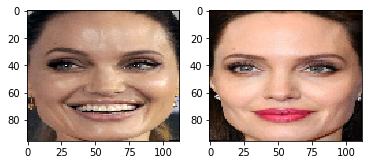

(8.224462, 0.744376, 0.2770478129386902)

In [11]:
verify("deepface/tests/dataset/img1.jpg", "deepface/tests/dataset/img2.jpg", show = True)

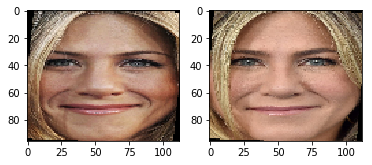

(8.461076, 0.8440226, 0.35618704557418823)

In [12]:
verify("deepface/tests/dataset/img54.jpg", "deepface/tests/dataset/img3.jpg", show = True)

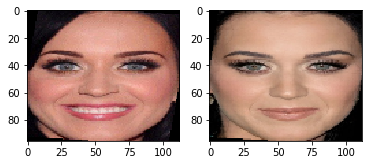

(6.70001, 0.7665266, 0.2937815189361572)

In [13]:
verify("deepface/tests/dataset/img42.jpg", "deepface/tests/dataset/img45.jpg", show = True)

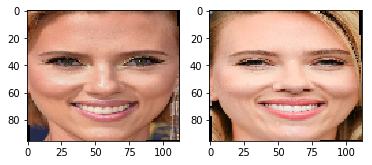

(9.932768, 0.8279068, 0.3427148461341858)

In [14]:
verify("deepface/tests/dataset/img9.jpg", "deepface/tests/dataset/img49.jpg", show = True)

## False positives

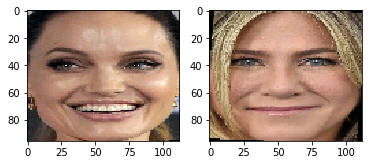

(8.232154, 0.7918342, 0.31350070238113403)

In [15]:
verify("deepface/tests/dataset/img1.jpg", "deepface/tests/dataset/img3.jpg", show = True)

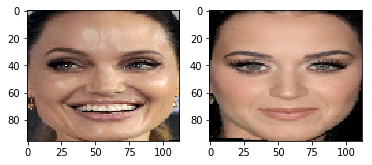

(7.3615932, 0.8704549, 0.37884581089019775)

In [16]:
verify("deepface/tests/dataset/img1.jpg", "deepface/tests/dataset/img45.jpg", show = True)

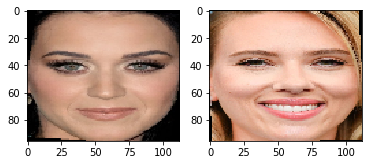

(5.359951, 0.79654187, 0.3172394633293152)

In [17]:
verify("deepface/tests/dataset/img45.jpg", "deepface/tests/dataset/img49.jpg", show = True)